In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,  
    shuffle_files=True, 
    with_info=True,
)

#### 에러 해결
기존 코드로 진행했을 경우, dict 형태로 받았지만 `as_supervised=True`일 경우 튜플 형태로 받는다. 

In [4]:
# 데이터 개수 확인 
print('train :', tf.data.experimental.cardinality(ds_train))
print('test  :', tf.data.experimental.cardinality(ds_test))

train : tf.Tensor(12000, shape=(), dtype=int64)
test  : tf.Tensor(8580, shape=(), dtype=int64)


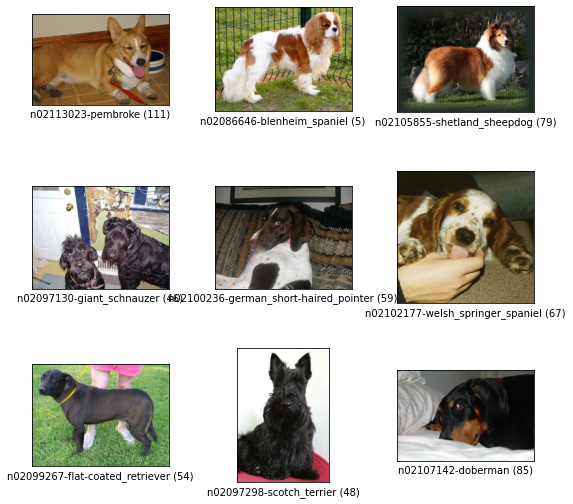

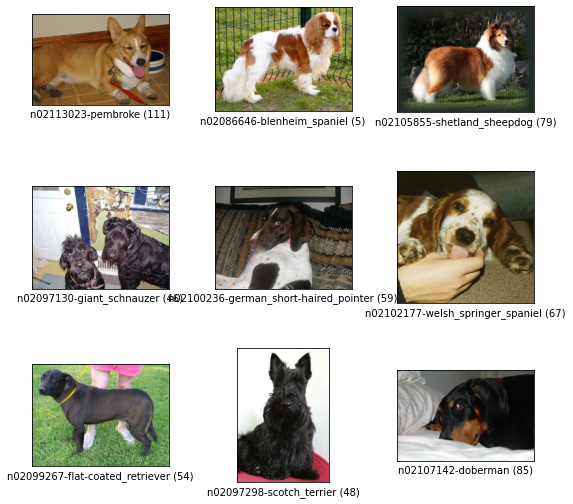

In [5]:
tfds.show_examples(ds_train, ds_info)

## 1. Augmentation을 적용한 데이터셋 만들기

In [6]:
## 이미지 사이즈 조정 및 정규화
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [7]:
## 데이터 증강 함수1
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

## 데이터 증강 함수2
def augment2(image,label):
    # 랜덤 좌우 반전
    image = tf.image.random_flip_left_right(image)
    
    # 랜덤 상하 반전
    image = tf.image.random_flip_up_down(image)
    
    # 랜덤 회전 (90도 단위)
    random_rotations = tf.random.uniform([], minval=0, maxval=4, dtype=tf.int32)
    image = tf.image.rot90(image, k=random_rotations)
    
    # 랜덤 밝기 조정
    image = tf.image.random_brightness(image, max_delta=0.3)
    
    # 랜덤 대비 조정
    image = tf.image.random_contrast(image, lower=0.7, upper=1.3)
    
    # 랜덤 채도 조정 (컬러 이미지일 경우)
    if image.shape[-1] == 3:  # RGB 이미지일 때만 적용
        image = tf.image.random_saturation(image, lower=0.7, upper=1.3)
    
    # 랜덤 크기 조정 후 자르기 (줌인 효과)
    scale = tf.random.uniform([], minval=0.8, maxval=1.0)
    new_size = tf.cast(tf.shape(image)[:2] * scale, tf.int32)
    image = tf.image.resize(image, new_size)
    image = tf.image.resize_with_crop_or_pad(image, target_height=tf.shape(image)[0], target_width=tf.shape(image)[1])
    
    # 랜덤 노이즈 추가
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.02, dtype=tf.float32)
    image = image + noise
    
    # 값 클리핑 (0~1 사이로 유지)
    image = tf.clip_by_value(image, 0, 1)
    
    return image, label

In [8]:
## 라벨 원-핫 인코딩
def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

#### Cutmix

In [9]:
## 이미지 증강: cutmix
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+height//2)
    
    return x_min, y_min, x_max, y_max

## mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

## mix two labels
def mix_2_labels(image_a, label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

In [10]:
## Cutmix 함수
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(image_a, label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

#### Mixup

In [11]:
## 이미지 증강: mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

In [12]:
## Mixup
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

### 전처리 적용

In [13]:
## 전처리 함수들 적용
def apply_normalize_on_dataset(
    ds, 
    is_test=False, 
    batch_size=16, 
    with_aug=False, 
    with_cutmix=False,
    with_mixup=False,
#     aug_func=augment
):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    
    ## test 데이터가 아니면서 aug를 할 데이터 셋
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    
    ## test 데이터가 아니면서 cutmix 할 데이터 셋
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )

    ## test 데이터가 아니면서 mixup 할 데이터 셋
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
        
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
        
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [14]:
num_classes = ds_info.features["label"].num_classes

In [15]:
## No Augmentation
ds_train_original = apply_normalize_on_dataset(
    ds_train,
    is_test=False, 
    with_aug=False,
    with_cutmix=False
)

## 기본 Augmentation
ds_train_aug = apply_normalize_on_dataset(
    ds_train,
    is_test=False, 
    with_aug=True,
    with_cutmix=False,
    with_mixup=False,
)

# ## 기본 Augmentation2
# ds_train_aug2 = apply_normalize_on_dataset(
#     ds_train,
#     is_test=False, 
#     with_aug=True,
#     with_cutmix=False, 
#     with_mixup=False,
#     aug_func=augment2
# )

## CutMix만 적용
ds_train_cutmix = apply_normalize_on_dataset(
    ds_train,
    is_test=False, 
    with_aug=False,
    with_cutmix=True, 
    with_mixup=False    
)

## 기본 Augmentation + CutMix 적용
ds_train_aug_cutmix = apply_normalize_on_dataset(
    ds_train,
    is_test=False, 
    with_aug=True,
    with_cutmix=True,
    with_mixup=False
)

## Mixup만 적용
ds_train_mixup = apply_normalize_on_dataset(
    ds_train,
    is_test=False, 
    with_aug=False,
    with_cutmix=False,
    with_mixup=True    
)

## 기본 Augmentation + Mixup 적용
ds_train_aug_mixup = apply_normalize_on_dataset(
    ds_train,
    is_test=False, 
    with_aug=True,
    with_cutmix=False, 
    with_mixup=True
)

## test 셋에 대한 전처리
ds_test = apply_normalize_on_dataset(
    ds_test,
    is_test=True, 
    with_aug=False,
    with_cutmix=False
)

#### 데이터셋
1. No Augmentation
2. 기본 Augmentation
3. 기본 Augmentation2
3. CutMix만 적용
4. 기본 Augmentation + CutMix 적용
5. Mixup만 적용
6. 기본 Augmentation + Mixup 적용

## 2. 모델 만들기

In [24]:
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [25]:
resnet50_aug = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [26]:
resnet50_only_cutmix = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [27]:
resnet50_only_mixup = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [28]:
resnet50_aug.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense_4 (Dense)              (None, 120)               245880    
Total params: 23,833,592
Trainable params: 23,780,472
Non-trainable params: 53,120
_________________________________________________________________


## 3. 모델 훈련하기

In [29]:
EPOCH = 20

In [30]:
import os
# 체크포인트 저장 경로 설정
checkpoint_path = "checkpoints/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# 체크포인트 콜백 정의
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,    # 모델 가중치만 저장
    save_best_only=True,       # 검증 손실이 가장 낮을 때만 저장
    monitor='val_loss',        # 검증 손실 기준
    mode='min',                # 검증 손실이 가장 낮을 때 저장
    save_freq='epoch',         # 매 epoch 마다 저장
    verbose=1                  # 저장 시 메시지 출력
)

#### 1. No Augmentation 학습

In [31]:
for images, labels in ds_train_original.take(1):
    print(images.shape)  # (batch_size, height, width, channels)
    print(labels.shape)  # (batch_size,)

(16, 224, 224, 3)
(16, 120)


In [32]:
for images, labels in ds_test.take(1):
    print(images.shape)  # (batch_size, height, width, channels)
    print(labels.shape)  # (batch_size,)

(16, 224, 224, 3)
(16, 120)


In [33]:
resnet50.compile(
    loss='categorical_crossentropy',
    optimizer='adam', ## tf.keras.optimizers.SGD(lr=0.01)
    metrics=['accuracy'],
)

history_resnet50 = resnet50.fit(
    ds_train_original, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[checkpoint_callback]
)

Epoch 1/20
750/750 [==============================] - 196s 207ms/step - loss: 4.7912 - accuracy: 0.0143 - val_loss: 4.8338 - val_accuracy: 0.0118

Epoch 00001: val_loss improved from inf to 4.83384, saving model to checkpoints/cp-0001.ckpt
Epoch 2/20
750/750 [==============================] - 156s 207ms/step - loss: 4.5427 - accuracy: 0.0251 - val_loss: 4.8450 - val_accuracy: 0.0191

Epoch 00002: val_loss did not improve from 4.83384
Epoch 3/20
750/750 [==============================] - 156s 208ms/step - loss: 4.1970 - accuracy: 0.0528 - val_loss: 4.4866 - val_accuracy: 0.0522

Epoch 00003: val_loss improved from 4.83384 to 4.48661, saving model to checkpoints/cp-0003.ckpt
Epoch 4/20
750/750 [==============================] - 156s 208ms/step - loss: 3.8413 - accuracy: 0.0898 - val_loss: 4.7503 - val_accuracy: 0.0345

Epoch 00004: val_loss did not improve from 4.48661
Epoch 5/20
750/750 [==============================] - 155s 207ms/step - loss: 3.4730 - accuracy: 0.1449 - val_loss: 3.99

In [37]:
import pickle

with open("history_resnet50.pkl", "wb") as f:
    pickle.dump(history_resnet50.history, f)

#### 2. 기본 Augmentation 학습

In [38]:
resnet50_aug.compile(
    loss='categorical_crossentropy',
    optimizer='adam', ## tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug = resnet50_aug.fit(
    ds_train_aug,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 164s 207ms/step - loss: 4.7781 - accuracy: 0.0131 - val_loss: 4.7882 - val_accuracy: 0.0177
Epoch 2/20
750/750 [==============================] - 155s 207ms/step - loss: 4.5437 - accuracy: 0.0263 - val_loss: 4.6653 - val_accuracy: 0.0340
Epoch 3/20
750/750 [==============================] - 155s 207ms/step - loss: 4.1836 - accuracy: 0.0587 - val_loss: 5.4176 - val_accuracy: 0.0202
Epoch 4/20
750/750 [==============================] - 155s 207ms/step - loss: 3.8010 - accuracy: 0.0945 - val_loss: 4.4194 - val_accuracy: 0.0646
Epoch 5/20
750/750 [==============================] - 155s 207ms/step - loss: 3.4913 - accuracy: 0.1417 - val_loss: 4.3938 - val_accuracy: 0.0711
Epoch 6/20
750/750 [==============================] - 155s 207ms/step - loss: 3.1808 - accuracy: 0.1973 - val_loss: 5.8587 - val_accuracy: 0.0596
Epoch 7/20
750/750 [==============================] - 155s 207ms/step - loss: 2.8370 - accuracy: 0.2607 - val_loss: 4.5533 -

In [39]:
with open("history_resnet50_aug.pkl", "wb") as f:
    pickle.dump(history_resnet50_aug.history, f)

#### 3. CutMix만 적용

In [40]:
resnet50_only_cutmix.compile(
    loss='categorical_crossentropy',
    optimizer='adam', ## tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_only_cutmix = resnet50_only_cutmix.fit(
    ds_train_cutmix,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 166s 209ms/step - loss: 4.7991 - accuracy: 0.0123 - val_loss: 4.8608 - val_accuracy: 0.0135
Epoch 2/20
750/750 [==============================] - 156s 208ms/step - loss: 4.6897 - accuracy: 0.0198 - val_loss: 4.7416 - val_accuracy: 0.0240
Epoch 3/20
750/750 [==============================] - 156s 208ms/step - loss: 4.5687 - accuracy: 0.0327 - val_loss: 4.6052 - val_accuracy: 0.0238
Epoch 4/20
750/750 [==============================] - 156s 208ms/step - loss: 4.4581 - accuracy: 0.0444 - val_loss: 4.4018 - val_accuracy: 0.0368
Epoch 5/20
750/750 [==============================] - 156s 209ms/step - loss: 4.3712 - accuracy: 0.0544 - val_loss: 4.1575 - val_accuracy: 0.0668
Epoch 6/20
750/750 [==============================] - 156s 209ms/step - loss: 4.2715 - accuracy: 0.0729 - val_loss: 4.4176 - val_accuracy: 0.0619
Epoch 7/20
750/750 [==============================] - 156s 209ms/step - loss: 4.1705 - accuracy: 0.0905 - val_loss: 4.9079 -

In [41]:
with open("history_resnet50_only_cutmix.pkl", "wb") as f:
    pickle.dump(history_resnet50_only_cutmix.history, f)

#### 4. Mixup만 적용

In [42]:
resnet50_only_mixup.compile(
    loss='categorical_crossentropy',
    optimizer='adam', ## tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_only_mixup = resnet50_only_mixup.fit(
    ds_train_mixup,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 166s 209ms/step - loss: 4.8344 - accuracy: 0.0111 - val_loss: 4.8280 - val_accuracy: 0.0069
Epoch 2/20
750/750 [==============================] - 156s 208ms/step - loss: 4.7752 - accuracy: 0.0122 - val_loss: 5.3315 - val_accuracy: 0.0129
Epoch 3/20
750/750 [==============================] - 156s 208ms/step - loss: 4.7238 - accuracy: 0.0179 - val_loss: 4.8236 - val_accuracy: 0.0190
Epoch 4/20
750/750 [==============================] - 172s 229ms/step - loss: 4.6532 - accuracy: 0.0224 - val_loss: 4.7362 - val_accuracy: 0.0251
Epoch 5/20
750/750 [==============================] - 156s 208ms/step - loss: 4.5826 - accuracy: 0.0268 - val_loss: 4.7453 - val_accuracy: 0.0156
Epoch 6/20
750/750 [==============================] - 156s 208ms/step - loss: 4.5012 - accuracy: 0.0389 - val_loss: 4.6990 - val_accuracy: 0.0403
Epoch 7/20
750/750 [==============================] - 156s 208ms/step - loss: 4.4283 - accuracy: 0.0512 - val_loss: 4.2754 -

In [43]:
with open("history_resnet50_only_mixup.pkl", "wb") as f:
    pickle.dump(history_resnet50_only_mixup.history, f)

| method      | loss   | accuracy | val_loss | val_accuracy |
| ----------  | ------ | -------- | -------- | ------------ |
| no aug      | 0.0998 | 0.9736   | 3.7353   | 0.2938       |
| only aug    | 0.1894 | 0.9459   | 3.0032   | 0.3372       |
| only cutmix | 2.3892 | 0.5928   | 3.1091   | 0.2726       |
| only mixup  | 3.0657 | 0.4287   | 3.5353   | 0.1799       |

## 4. 훈련 과정 시각화하기

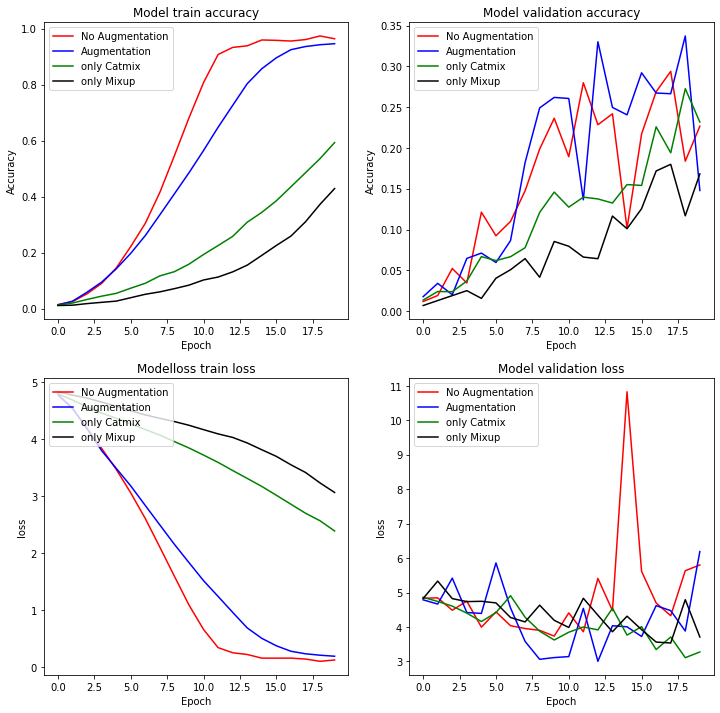

In [46]:
plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
plt.plot(history_resnet50.history['accuracy'], 'r')
plt.plot(history_resnet50_aug.history['accuracy'], 'b')
plt.plot(history_resnet50_only_cutmix.history['accuracy'], 'g')
plt.plot(history_resnet50_only_mixup.history['accuracy'], 'black')

plt.title('Model train accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'Augmentation', 'only Catmix', 'only Mixup'], loc='upper left')

plt.subplot(2,2,2)
plt.plot(history_resnet50.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_only_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_only_mixup.history['val_accuracy'], 'black')

plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'Augmentation', 'only Catmix', 'only Mixup'], loc='upper left')

plt.subplot(2,2,3)
plt.plot(history_resnet50.history['loss'], 'r')
plt.plot(history_resnet50_aug.history['loss'], 'b')
plt.plot(history_resnet50_only_cutmix.history['loss'], 'g')
plt.plot(history_resnet50_only_mixup.history['loss'], 'black')

plt.title('Modelloss train loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'Augmentation', 'only Catmix', 'only Mixup'], loc='upper left')

plt.subplot(2,2,4)
plt.plot(history_resnet50.history['val_loss'], 'r')
plt.plot(history_resnet50_aug.history['val_loss'], 'b')
plt.plot(history_resnet50_only_cutmix.history['val_loss'], 'g')
plt.plot(history_resnet50_only_mixup.history['val_loss'], 'black')

plt.title('Model validation loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'Augmentation', 'only Catmix', 'only Mixup'], loc='upper left')
plt.show()

catmix 와 mixup의 train acc와 loss를 확인해본 결과 아직 충분히 학습이 되지 않았다고 생각된다. 

#### 왜 cutmix loss가 더 높을까?
모델은 고정, 데이터는 변동,  
오버피팅이 잘되었는가  
첫번째 방법의 에폭을 충분히 설정해서 언제 오버피팅이 이루어지는지 확인해야한다.  
조건 통제, 목표 도달  
lr를 조절해서 빠르게 도달  
첫번째 모델 실험에서 많은 정보를 얻어야한다.  

cutmix 와 mixup  
정확도가 더 낮다.  
왜 그럴까?  
프로젝트에서의 성능과 우리가 원하는 목표의 차이  
모델이 실제로 사용하는 환경에 맞추고 싶엇던 것  
모델이 잘 모르는 상황에서도 잘 맞추는 것이 중요  

모델의 강건성 -> 모델의 정확도  

#### Valid set과 Test set의 차이점, 강건성
validation set의 경우, 학습 과정에서의 파라미터 업데이트에는 사용되지 않지만 하이퍼파라미터 조정에 사용된다. 또한 과적합이 되는지 확인할 수 있다. 

test set의 경우, 최종적으로 모델의 일반화 성능을 평가하기 위한 데이터로 학습이나 검증에 사용되지 않은 데이터이다.  

강건성을 확인하기 위해서는 test set을 미리 설정하고 모든 학습이 끝난 후 test set을 통해 모델의 성능을 확인하고 비교하면 될 것이라고 생각한다.  

## 회고
acc 와 loss를 그려서 충분히 과적합을 넘겼는지 확인하는 습관을 갖자.  
실험 목표를 정하고 그 목표에 맞게 프로젝트를 진행해가자.